In [17]:
# load packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import warnings
import time
from IPython.utils import io

warnings.filterwarnings("ignore")

### Prepare data for training

In [2]:
# read in data / process data 
df = pd.read_csv('data/processed-data-02-07.csv', index_col =0)

In [3]:
# take out anything with wind_10m, date
df = df.loc[:, df.columns[~df.columns.astype('str').str.contains('wind_10m')]]
df = df.drop(columns="date")

In [4]:
X = df.copy().drop(columns=["is_heat"])
y = df["is_heat"]

In [5]:
# split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=512,
                                                    stratify = y
                                                   )

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.125, random_state=512,
                                                    stratify = y_train
                                                   )

### Select subsets

In [ ]:
# select a small subset of features

# 36 subsets
# hi, air temp, wbgt

# only day of 
# 1-day, 3-day 
# 3 day, 5 day 

# just mean 
# mean, max, var
# mean, max
# mean, var 

# list of lists 

In [7]:
subsets= []
cols = X_train.columns
cols = cols[~cols.str.contains('min')]

# first subset by mean / max /var
mean_c = cols[cols.str.contains('mean')]
mean_max_c = cols[cols.str.contains('mean|max')]
mean_var_c = cols[cols.str.contains('mean|var')]

# for each of cols, mean_c, mean_max_c, mean_var_c
for cols_i in [cols,mean_c, mean_max_c, mean_var_c]:
    # take out 3 or 5 lag 
    a = cols_i[~cols_i.str.contains('lag')]
    # take out 3 lag 
    b = cols_i[~cols_i.str.contains('lag3')]
    # take out 5 lag 
    c = cols_i[~cols_i.str.contains('lag5')]
    for cols_j in [a, b, c]:
        # take out air temp, wbgt
        subsets.append(cols_j[~cols_j.str.contains('air_temp|wbgt')])
        # take out hi, wbgt
        subsets.append(cols_j[~cols_j.str.contains('hi|wbgt')])
        # take out hi, air temp
        subsets.append(cols_j[~cols_j.str.contains('hi|air_temp')])

### Cross-validation Training

In [ ]:
# for each of these subsets 
# run gridsearch cv on the models 
# for each model / resampling method option, calculate cross val score on best params 

# for the subset, store the avg F1 for each combination of resampling and model 

#### Function for storing results

In [8]:
def store_best_res(res_list, res, X_refit, y_refit, model, resampling_type, subset_ind, neighbors=None):
    '''takes a grid search cv fit, calculates 5 fold cross val scores based 
    on best params fit and stores into cv_res 
    which feature subset, model, resampling, the resampling params (if app),
    the model's best params, avg cross val F1, std cross val F1''' 
    # cross val score
    scores = cross_val_score(res, X_refit, y_refit, scoring='f1_weighted')
    
    # get val score
    val_f1 = f1_score(res.predict(X_val[subsets[subset_ind]]), y_val)
    
    
    res_df = pd.DataFrame(np.array([[subset_ind, model, resampling_type, neighbors, res.best_params_, scores.mean(), scores.std(), val_f1]]),
                            columns=["subset", "model", "resampling_method", "neighbors", "params", "mean_cv_F1_score", "std_cv_F1_score", "val_f1"])
    
    return res_list.append(res_df)

#### Initializing things that don't need to be in for loop

In [9]:
# initialize stratified k fold 
folds = StratifiedKFold(n_splits=5, random_state=512, shuffle=True)

# no resampling 
none_en_pipe = imbPipeline([
    ('classifier', LogisticRegression()) 
])

none_xg_pipe = imbPipeline([
    ('classifier', XGBClassifier()) 
])

# set params for steps of pipeline 
xg_param_grid = [
    {'classifier' : [XGBClassifier()],
    'classifier__n_estimators' : list(range(25,250,50)),
     'classifier__max_depth' : list(range(1,4)),
     'classifier__eta' : list(np.arange(0.1,0.5,0.2))
    }]

en_param_grid = [
    {'classifier' : [LogisticRegression(penalty='elasticnet', solver='saga', tol = 0.01)],
    'classifier__l1_ratio' : list(np.arange(0.1, 1., 0.2)),
    'classifier__C': list(np.arange(0.1, 1., 0.2))}
]

In [94]:
for i in np.arange(0.1, 1., 0.2):
    print(i)

0.1
0.30000000000000004
0.5000000000000001
0.7000000000000001
0.9000000000000001


#### for loop of training!!!

In [10]:
%%capture --no-display
for i, features_j in enumerate(subsets):
    # initialize time 
    start_time = time.time()
    
    # subset X for features j 
    X_train_j = X_train[features_j]
    # initialize list to store results for each subset 
    cv_res_i = []
    
    ## NO RESAMPLING 
    # grid search 
    none_en_gscv = GridSearchCV(none_en_pipe, param_grid = en_param_grid, 
          cv = folds, verbose=0, scoring="f1_weighted")
    none_xg_gscv = GridSearchCV(none_xg_pipe, param_grid = xg_param_grid, 
          cv = folds, verbose=0, scoring="f1_weighted")
    # fit 
    none_en_gscv.fit(X_train_j, y_train)
    none_xg_gscv.fit(X_train_j, y_train)
    # store res 
    store_best_res(cv_res_i, none_en_gscv, X_train_j, y_train, 'elastic_net', 'none', i)
    store_best_res(cv_res_i, none_xg_gscv, X_train_j, y_train, 'xgboost', 'none', i)
    
    print('done with no resampling of subset ', i)
    

    ## RESAMPLING 
    for smote_n in [3,5,7]:
        # smote en
        smote_en_pipe = imbPipeline([
            ('over', SMOTE(sampling_strategy = 0.55, k_neighbors= smote_n)),
            ('classifier', LogisticRegression()) 
        ])
        # smote xg
        smote_xg_pipe = imbPipeline([
            ('over', SMOTE(sampling_strategy = 0.55, k_neighbors= smote_n)),
            ('classifier', XGBClassifier()) 
        ])
        # smote and undersampling en
        both_en_pipe = imbPipeline([
            ('over', SMOTE(sampling_strategy = 0.55, k_neighbors= smote_n)), 
            ('under', RandomUnderSampler()),
            ('classifier', LogisticRegression()) 
        ])
        # smote and undersampling xg
        both_xg_pipe = imbPipeline([
            ('over', SMOTE(sampling_strategy = 0.55, k_neighbors= smote_n)), 
            ('under', RandomUnderSampler()),
            ('classifier', XGBClassifier()) 
        ])

        # grid search  
        smote_en_gscv = GridSearchCV(smote_en_pipe, param_grid = en_param_grid, 
                                 cv = folds, verbose=0, scoring="f1_weighted")
        smote_xg_gscv = GridSearchCV(smote_xg_pipe, param_grid = xg_param_grid, 
                                 cv = folds, verbose=0, scoring="f1_weighted")
        both_en_gscv = GridSearchCV(both_en_pipe, param_grid = en_param_grid, 
                                  cv = folds, verbose=0, scoring="f1_weighted")
        both_xg_gscv = GridSearchCV(both_xg_pipe, param_grid = xg_param_grid, 
                                  cv = folds, verbose=0, scoring="f1_weighted")
        
        # fit 
        smote_en_gscv.fit(X_train_j, y_train)
        smote_xg_gscv.fit(X_train_j, y_train)
        both_en_gscv.fit(X_train_j, y_train)
        both_xg_gscv.fit(X_train_j, y_train)
        
        store_best_res(cv_res_i, smote_en_gscv, X_train_j, y_train, 'elastic_net', 'smote', i, smote_n)
        store_best_res(cv_res_i, smote_xg_gscv, X_train_j, y_train, 'xgboost', 'smote', i, smote_n)
        store_best_res(cv_res_i, both_en_gscv, X_train_j, y_train, 'elastic_net', 'both', i, smote_n)
        store_best_res(cv_res_i, both_xg_gscv, X_train_j, y_train, 'xgboost', 'both', i, smote_n)
        
        print('done with resampling of subset ', i, ' for neighbor ', smote_n)
    
    # for each subset, have list of dataframes 
    cv_res_i_df= pd.concat(cv_res_i)

    # write subset to pickle
    file_name = str(i) + '_subset_cv_res_v2.pickle'
    cv_res_i_df.to_pickle(file_name)
    
    print("Done with subset", str(i + 1), "/", len(subsets), 'in', np.round(time.time() - start_time), 'seconds')
    

### Final model tuning

In [11]:
# xgboost, both resampling, 24 subsets

X_train_24 = X_train[subsets[24]]

In [183]:
xg_param_grid_fin = [
    {'classifier' : [XGBClassifier()],
    'classifier__n_estimators' : list(range(25,250,50)),
     'classifier__max_depth' : list(range(1,4)),
     'classifier__eta' : list(np.arange(0.1,0.5,0.2))
    }]

both_xg_gscv = GridSearchCV(both_xg_pipe, param_grid = xg_param_grid_fin, 
          cv = folds, verbose=0, scoring="f1_weighted")

both_xg_pipe = imbPipeline([
    ('over', SMOTE(sampling_strategy = 0.55, k_neighbors=3)), 
    ('under', RandomUnderSampler()),
    ('classifier', XGBClassifier()) 
])

In [184]:
with io.capture_output() as captured:
    both_xg_gscv_24 = GridSearchCV(both_xg_pipe, param_grid = xg_param_grid_fin, 
          cv = folds, verbose=0, scoring="f1_weighted")
    both_xg_gscv_24.fit(X_train_24, y_train)

res_df = pd.DataFrame(both_xg_gscv_24.cv_results_)

In [ ]:
# fit 

In [185]:
f1_score(both_xg_gscv_24.predict(X_test[subsets[24]]), y_test)

0.33333333333333337

In [193]:
test_res = pd.DataFrame([both_xg_gscv_24.predict(X_test[subsets[24]]), y_test]).transpose()

In [195]:
test_res.set_axis(['Pred', 'Test'], axis=1, inplace=True)

In [210]:
test_res[(test_res.Test == True) & (test_res.Pred == False)]

,Pred,Test
30,False,True
67,False,True
80,False,True
98,False,True
137,False,True
145,False,True
197,False,True
223,False,True
232,False,True
243,False,True


In [208]:
test_res

,Pred,Test
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
533,False,False
534,False,False
535,False,False
536,False,False


In [201]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [200]:
precision_score(both_xg_gscv_24.predict(X_test[subsets[24]]), y_test)

0.4375

In [202]:
recall_score(both_xg_gscv_24.predict(X_test[subsets[24]]), y_test)

0.2692307692307692

### Variable Importance

In [84]:
# feature importance of tuned on train 
best_model_fi_df = pd.concat([pd.DataFrame(subsets[24]), 
                              pd.DataFrame(ss.rankdata(both_xg_gscv_24.best_estimator_.named_steps["classifier"].feature_importances_))], axis=1)
best_model_fi_df.set_axis(['var', 'fi'], axis=1, inplace=True)

array([0.02320521, 0.00985167, 0.01127513, 0.01057116, 0.0192065 ,
       0.03158407, 0.02694784, 0.03577646, 0.0078123 , 0.01034684,
       0.04094853, 0.23570737, 0.02009195, 0.00795735, 0.03633111,
       0.01029662, 0.01115976, 0.00537004, 0.01101649, 0.03145896,
       0.0300949 , 0.02381802, 0.02258407, 0.01232435, 0.02268232,
       0.02747469, 0.06085398, 0.03582096, 0.02135386, 0.05313914,
       0.01398159, 0.02991756, 0.00926814, 0.01255548, 0.00790122,
       0.01931436], dtype=float32)

In [90]:
best_model_fi_df.sort_values('fi')

,var,fi
17,lag3_hi_max,1.0
8,dewpoint_mean,2.0
34,lag5_wind_2m_mean,3.0
13,lag3_solar_max,4.0
32,lag5_dewpoint_mean,5.0
1,solar_max,6.0
15,lag3_humidity_max,7.0
9,humidity_mean,8.0
3,humidity_max,9.0
18,lag3_pressure_mean,10.0


In [28]:
both_xg_gscv_24.best_params_

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None,
               enable_categorical=False, eta=0.30000000000000004, gamma=None,
               gpu_id=None, importance_type=None, interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=3,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=225, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, reg_alpha=None,
               reg_lambda=None, scale_pos_weight=None, subsample=None,
               tree_method=None, validate_parameters=None, verbosity=None),
 'classifier__eta': 0.30000000000000004,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 225}

In [136]:
# for each of 10 folds, store feature importance score 
xgb_fi = XGBClassifier(eta=0.30000000000000004, max_depth=3, n_estimators=225)
fis = []

sm_fin = SMOTE(sampling_strategy = 0.55, k_neighbors= 5)
under_fin = RandomUnderSampler()

In [144]:
fis = []

In [145]:
with io.capture_output() as captured:
    size = np.round(0.8 * X_train_24.shape[0]).astype('int')
    samp_range = np.arange(X_train_24.shape[0])
    # for each of 10 folds 
    for i in range(10000):
        # sample 80% of data 
        inds = np.random.choice(samp_range, size=size, replace=False)
        # subset on the fold 
        X_i = X_train_24.iloc[inds]
        y_i = y_train.iloc[inds]
        
        # fit on best 
        X_sm, y_sm = sm_fin.fit_resample(X_i, y_i)
        X_both, y_both = under_fin.fit_resample(X_sm, y_sm)
        xgb_fi.fit(X_both, y_both)
        
        # get feature importances
        fis.append(xgb_fi.feature_importances_)


KeyboardInterrupt: 

In [147]:
len(fis)

8618

In [148]:
fis = np.asarray(fis)

In [149]:
fis_mean = fis.mean(axis=0)

In [112]:
# vector of variables 
variables = pd.DataFrame(subsets[24])

In [170]:
fi_df = pd.concat([variables, pd.DataFrame(fis_mean)], axis=1, names=['var', 'score'])
fi_df.set_axis(['Features', 'Avg. Feature Importance Score'], axis=1, inplace=True)

In [172]:
fi_df = fi_df.sort_values('Avg. Feature Importance Score', ascending=False)

In [173]:
top_10_fi = fi_df.iloc[0:10]

<AxesSubplot:xlabel='Avg. Feature Importance Score', ylabel='Features'>

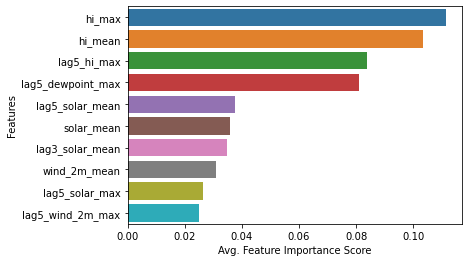

In [176]:
sns.barplot(data=top_10_fi, y = 'Features', x='Avg. Feature Importance Score')

In [ ]:
# concat variables with fis_mean
# rename 
# sort by rank 